In [1]:
!wget --no-check-certificate https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip 

--2019-04-19 20:54:57--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 2607:f8b0:400e:c09::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip.5’

cats_and_dogs_filte 100%[===================>]  65.43M  89.2MB/s    in 0.7s    

2019-04-19 20:54:58 (89.2 MB/s) - ‘cats_and_dogs_filtered.zip.5’ saved [68606236/68606236]



In [0]:
import os
import zipfile

local_zip = 'cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [3]:
base_dir = '/content/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

train_cat_fnames = os.listdir(train_cats_dir)
train_cat_fnames.sort()
print(train_cat_fnames[:10])
#print(train_cat_fnames[-10:])
#print()
train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort()
#print(train_dog_fnames[:10])
#print(train_dog_fnames[-10:])

['cat.0.jpg', 'cat.1.jpg', 'cat.10.jpg', 'cat.100.jpg', 'cat.101.jpg', 'cat.102.jpg', 'cat.103.jpg', 'cat.104.jpg', 'cat.105.jpg', 'cat.106.jpg']


In [4]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print()
print('total validation cat images:', len((os.listdir(validation_cats_dir))))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total training cat images: 1000
total training dog images: 1000

total validation cat images: 500
total validation dog images: 500


#Display some images

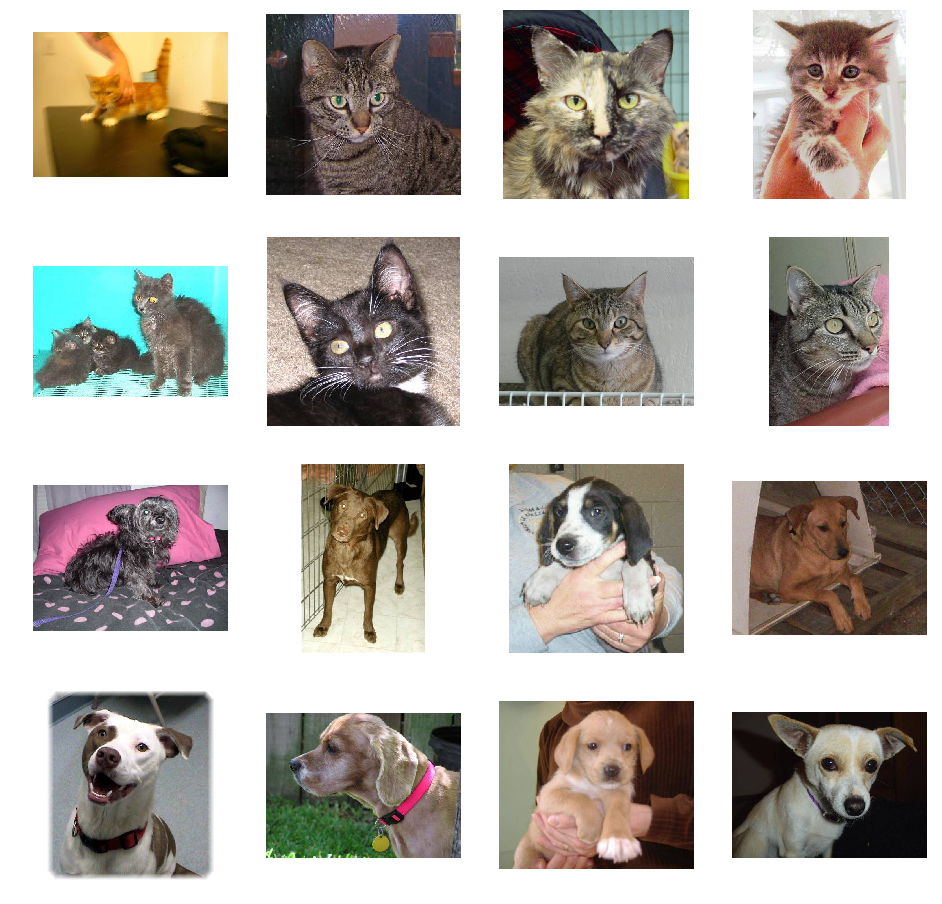

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 6x6 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)
pic_index += 8
next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[pic_index-8:pic_index]]
next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pix + next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

#Problem 1: Feature extraction with data augmentation
Build Network with VGG19
Use GPU with tensorflow

In [6]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

Found GPU at: /device:GPU:0


In [7]:
from keras.applications import VGG19

conv_base = VGG19(
    weights='imagenet', 
    include_top=False, 
    input_shape=(150, 150, 3))

Instructions for updating:
Colocations handled automatically by placer.


Using TensorFlow backend.


#Frezee the convolutional base

Concatenate the convolutional base and densely connected layers

In [0]:
from keras import layers
from keras import models
from keras import optimizers

conv_base.trainable = False

#copy vgg19 layers into our model
#model = models.Sequential()

#for layer in conv_base.layers:
#    model.add(layer)  
    
#freezing vgg19 layers (saving its original weights)
#for i in model.layers:
#  i.trainable = False

#Concatenate the convulutional base and densely connected layers

In [0]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
#model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))

In [10]:
#check layers trainability
num_layers = len(model.layers)
for x in range(0,num_layers):
    print("%s: %s"%(model.layers[x].name,str(model.layers[x].trainable)))

vgg19: False
flatten_1: True
dense_1: True
dense_2: True


#Apply data augmentation and Train the model
End to end with frozen convolutional base

In [11]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

# data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

# compile model

model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.RMSprop(lr=2e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=50
)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Instructions for updating:
Use tf.cast instead.
Epoch 1/15
100/100 [==============================] - 24s 237ms/step - loss: 0.6076 - acc: 0.6655 - val_loss: 0.4764 - val_acc: 0.8020
Epoch 2/15
100/100 [==============================] - 19s 194ms/step - loss: 0.5134 - acc: 0.7630 - val_loss: 0.4238 - val_acc: 0.8150
Epoch 3/15
100/100 [==============================] - 20s 196ms/step - loss: 0.4692 - acc: 0.7855 - val_loss: 0.3653 - val_acc: 0.8460
Epoch 4/15
100/100 [==============================] - 19s 192ms/step - loss: 0.4447 - acc: 0.8035 - val_loss: 0.3591 - val_acc: 0.8430
Epoch 5/15
100/100 [==============================] - 20s 196ms/step - loss: 0.4291 - acc: 0.8015 - val_loss: 0.3286 - val_acc: 0.8610
Epoch 6/15
100/100 [==============================] - 19s 187ms/step - loss: 0.4125 - acc: 0.8165 - val_loss: 0.3140 - val_acc: 0.8650
Epoch 7/15
100/100 [==============================] - 20s 

#Display curves of loss and accuracy during training

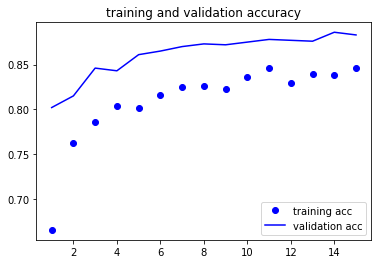

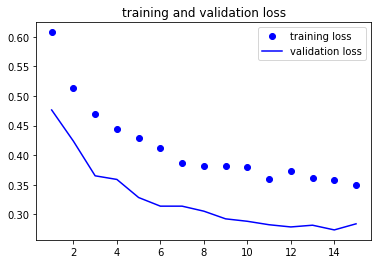

Validation loss: 0.28443538561463355
Validation accuracy: 0.8799999976158142


In [12]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

#Print out validation loss and accuracy
val_loss, val_acc = model.evaluate_generator(validation_generator, steps=50)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

#Problem 2: Fine-tuning with data augmentation

In [0]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [14]:
#check layers trainability
num_layers = len(model.layers)
for x in range(0,num_layers):
    print("%s: %s"%(model.layers[x].name,str(model.layers[x].trainable)))

vgg19: True
flatten_1: True
dense_1: True
dense_2: True


In [15]:
from keras.callbacks import ModelCheckpoint

# compile model

model.compile(
    loss='binary_crossentropy',
    #
    # choose a smaller learning rate
    #
    optimizer=optimizers.RMSprop(lr=1e-5), 
    metrics=['acc'])


#save the best weights
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", 
                               monitor = 'val_acc',
                               verbose=1, 
                               save_best_only=True)

# train
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=50,
    callbacks=[checkpointer])

Epoch 1/15
100/100 [==============================] - 22s 220ms/step - loss: 0.3425 - acc: 0.8535 - val_loss: 0.2472 - val_acc: 0.8900

Epoch 00001: val_acc improved from -inf to 0.89000, saving model to best_weights.hdf5
Epoch 2/15
100/100 [==============================] - 20s 200ms/step - loss: 0.3013 - acc: 0.8735 - val_loss: 0.1951 - val_acc: 0.9190

Epoch 00002: val_acc improved from 0.89000 to 0.91900, saving model to best_weights.hdf5
Epoch 3/15
100/100 [==============================] - 19s 193ms/step - loss: 0.2618 - acc: 0.8925 - val_loss: 0.2059 - val_acc: 0.9170

Epoch 00003: val_acc did not improve from 0.91900
Epoch 4/15
100/100 [==============================] - 20s 201ms/step - loss: 0.2416 - acc: 0.9010 - val_loss: 0.2266 - val_acc: 0.9130

Epoch 00004: val_acc did not improve from 0.91900
Epoch 5/15
100/100 [==============================] - 19s 191ms/step - loss: 0.2318 - acc: 0.8965 - val_loss: 0.1662 - val_acc: 0.9330

Epoch 00005: val_acc improved from 0.91900 to

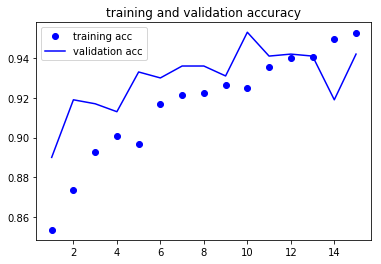

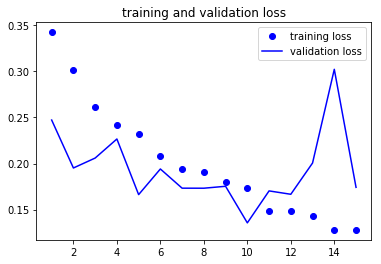

Validation loss: 0.1887551819719374
Validation accuracy: 0.941999990940094


In [16]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

val_loss, val_acc = model.evaluate_generator(validation_generator, steps=50)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

#Save the model

In [17]:
#load best weights
model.load_weights('best_weights.hdf5')

model_fname = 'cats_and_dogs.h5' 
model.save(model_fname)
model.summary()
#from google.colab import files

#with open(model_fname, 'r') as f:
#  files.download(model_fname)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 22,122,049
Trainable params: 11,536,897
Non-trainable params: 10,585,152
_________________________________________________________________


#Problem 3: Visualize of class activation maps (CAM)

For the model obtained in Problem 2

Adapted from: https://github.com/jacobgil/keras-cam/blob/master/cam.py

In [0]:
from keras.applications.vgg19 import VGG19
 
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input, decode_predictions
import cv2
from google.colab.patches import cv2_imshow
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from keras import backend as K

In [0]:
model = VGG19(weights='imagenet')
last_conv_layer = model.get_layer('block5_conv4')

In [0]:
def show_superimposed_image(img_path, heatmap):

  img = cv2.imread(img_path)
  # resize the heatmap to be the same size as the original image
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

  heatmap = np.uint8(255 * heatmap)

  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

  superimposed_img = heatmap * 0.4 + img

  cv2_imshow(superimposed_img)


def show_heatmap_vgg19(img_path, idx=0):
  img = image.load_img(img_path, target_size=(224, 224))
  #
  plt.imshow(img)
  plt.grid(None)
  plt.show()
  #
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  #
  preds = model.predict(x)
  print('Predicted:', decode_predictions(preds, top=3)[0])
  #
  #class_index = np.argmax(preds[0])
  
  class_index = np.argsort(preds[0])[-(1+idx)]
  
  class_output = model.output[:, class_index]
  
  grads = K.gradients(class_output, last_conv_layer.output)[0]

  pooled_grads = K.mean(grads, axis=(0, 1, 2))

  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

  pooled_grads_value, conv_layer_output_value = iterate([x])

  for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

  heatmap = np.mean(conv_layer_output_value, axis=-1)
  
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  

  plt.matshow(heatmap)
  plt.grid(None)
  plt.show()
  #
  show_superimposed_image(img_path, heatmap)  

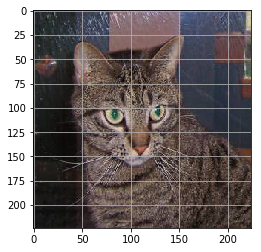

Predicted: [('n02123045', 'tabby', 0.44532606), ('n02123159', 'tiger_cat', 0.3137264), ('n02124075', 'Egyptian_cat', 0.13570867)]


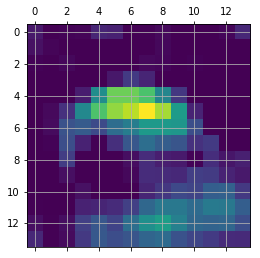

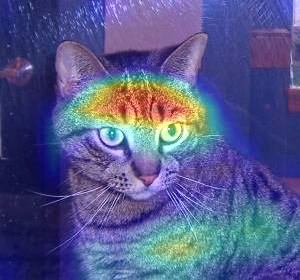

In [21]:
INPUT_IMAGE = '/content/cats_and_dogs_filtered/train/cats/cat.1.jpg'
show_heatmap_vgg19(INPUT_IMAGE)

#Problem 4: Build an activation model

It takes as input an image and produces as output the activation of the last conv layer of the model obtained in Problem 2.

Using this activation model obtain the corresponding activations for the validation images.

Apply t-SNE visualization to these activations to see how well the convnet separates cats fromdogs.

In [0]:
def load_model_weights(model, weights_path):
    print('Loading model.')
    f = h5py.File(weights_path)
    for k in range(f.attrs['nb_layers']):
        if k >= len(model.layers):
            # we don't look at the last (fully-connected) layers in the savefile
            break
        g = f['layer_{}'.format(k)]
        weights = [g['param_{}'.format(p)] for p in range(g.attrs['nb_params'])]
        model.layers[k].set_weights(weights)
        model.layers[k].trainable = False
    f.close()
    print('Model loaded.')
    return model

def get_output_layer(model, layer_name):
    # get the symbolic outputs of each "key" layer (we gave them unique names).
    layer_dict = dict([(layer.name, layer) for layer in model.layers])
    layer = layer_dict[layer_name]
    return layer

In [0]:
from keras.models import load_model,Model
def activation_model(model_path, img_path):
  img = image.load_img(img_path, target_size=(150, 150))
  #
  plt.imshow(img)
  plt.grid(None)
  plt.show()
  #
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  print(x.shape)
  model_a = load_model(model_path)

  layer_name = 'vgg19'
  ac_model = Model(inputs=model_a.input,
                                 outputs=model_a.get_layer(layer_name).get_output_at(-1))
  #x = cv2.resize(x,(150,150))
  output = ac_model.predict(x)
  print(ac_model.summary())
  print(output.shape)
  return output

In [0]:
model_path = 'best_weights.hdf5'
img_path = '/content/cats_and_dogs_filtered/train/cats/cat.1.jpg'

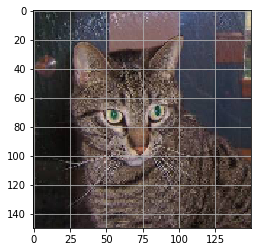

(1, 150, 150, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19_input (InputLayer)     (None, 150, 150, 3)       0         
_________________________________________________________________
vgg19 (Model)                (None, 4, 4, 512)         20024384  
Total params: 20,024,384
Trainable params: 9,439,232
Non-trainable params: 10,585,152
_________________________________________________________________
None
(1, 4, 4, 512)


array([[[[  0.       ,   0.       ,   0.       , ...,   0.       ,
            0.       ,   0.       ],
         [  0.       ,   0.       ,   0.       , ...,   0.       ,
            0.       ,   0.       ],
         [  0.       ,   0.       ,   0.       , ...,   0.       ,
            0.       ,   0.       ],
         [  0.       ,   0.       ,   0.       , ...,   0.       ,
            0.       ,  49.45067  ]],

        [[  0.       ,   0.       ,   0.       , ...,  18.3026   ,
            0.       ,  69.71216  ],
         [  0.       ,  95.11542  ,   0.       , ...,  34.80361  ,
            0.       ,   0.       ],
         [  0.       , 103.30126  ,   0.       , ...,   0.       ,
            0.       ,   0.       ],
         [  0.       ,  37.04231  ,   0.       , ...,   4.544661 ,
            0.       ,  68.94873  ]],

        [[  0.       ,   5.9822183,   0.       , ...,   0.       ,
            0.       ,  64.74041  ],
         [  0.       , 123.69137  ,   0.       , ...,   0.  

In [25]:
activation_model(model_path, img_path)

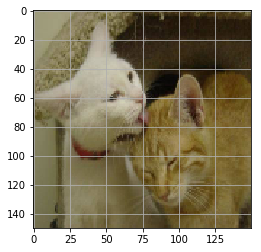

(1, 150, 150, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19_input (InputLayer)     (None, 150, 150, 3)       0         
_________________________________________________________________
vgg19 (Model)                (None, 4, 4, 512)         20024384  
Total params: 20,024,384
Trainable params: 9,439,232
Non-trainable params: 10,585,152
_________________________________________________________________
None
(1, 4, 4, 512)
(1, 4, 4, 512)


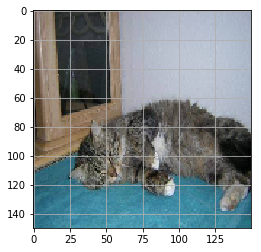

(1, 150, 150, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19_input (InputLayer)     (None, 150, 150, 3)       0         
_________________________________________________________________
vgg19 (Model)                (None, 4, 4, 512)         20024384  
Total params: 20,024,384
Trainable params: 9,439,232
Non-trainable params: 10,585,152
_________________________________________________________________
None
(1, 4, 4, 512)
(1, 4, 4, 512)


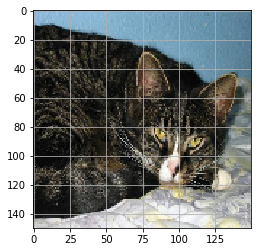

(1, 150, 150, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19_input (InputLayer)     (None, 150, 150, 3)       0         
_________________________________________________________________
vgg19 (Model)                (None, 4, 4, 512)         20024384  
Total params: 20,024,384
Trainable params: 9,439,232
Non-trainable params: 10,585,152
_________________________________________________________________
None
(1, 4, 4, 512)
(1, 4, 4, 512)


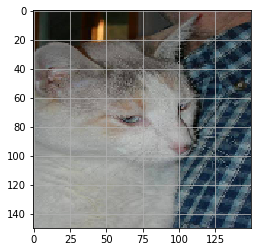

(1, 150, 150, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19_input (InputLayer)     (None, 150, 150, 3)       0         
_________________________________________________________________
vgg19 (Model)                (None, 4, 4, 512)         20024384  
Total params: 20,024,384
Trainable params: 9,439,232
Non-trainable params: 10,585,152
_________________________________________________________________
None
(1, 4, 4, 512)
(1, 4, 4, 512)


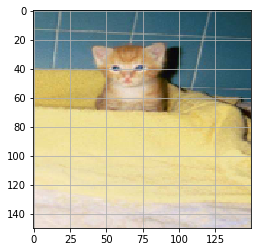

(1, 150, 150, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19_input (InputLayer)     (None, 150, 150, 3)       0         
_________________________________________________________________
vgg19 (Model)                (None, 4, 4, 512)         20024384  
Total params: 20,024,384
Trainable params: 9,439,232
Non-trainable params: 10,585,152
_________________________________________________________________
None
(1, 4, 4, 512)
(1, 4, 4, 512)


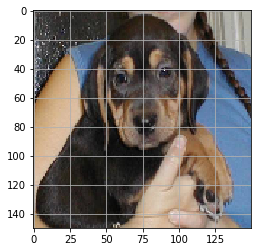

(1, 150, 150, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19_input (InputLayer)     (None, 150, 150, 3)       0         
_________________________________________________________________
vgg19 (Model)                (None, 4, 4, 512)         20024384  
Total params: 20,024,384
Trainable params: 9,439,232
Non-trainable params: 10,585,152
_________________________________________________________________
None
(1, 4, 4, 512)
(1, 4, 4, 512)


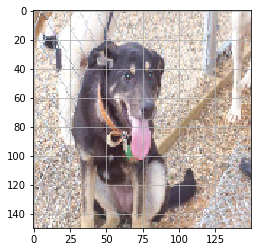

(1, 150, 150, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19_input (InputLayer)     (None, 150, 150, 3)       0         
_________________________________________________________________
vgg19 (Model)                (None, 4, 4, 512)         20024384  
Total params: 20,024,384
Trainable params: 9,439,232
Non-trainable params: 10,585,152
_________________________________________________________________
None
(1, 4, 4, 512)
(1, 4, 4, 512)


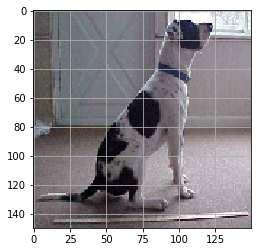

(1, 150, 150, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19_input (InputLayer)     (None, 150, 150, 3)       0         
_________________________________________________________________
vgg19 (Model)                (None, 4, 4, 512)         20024384  
Total params: 20,024,384
Trainable params: 9,439,232
Non-trainable params: 10,585,152
_________________________________________________________________
None
(1, 4, 4, 512)
(1, 4, 4, 512)


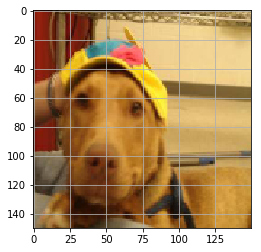

(1, 150, 150, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19_input (InputLayer)     (None, 150, 150, 3)       0         
_________________________________________________________________
vgg19 (Model)                (None, 4, 4, 512)         20024384  
Total params: 20,024,384
Trainable params: 9,439,232
Non-trainable params: 10,585,152
_________________________________________________________________
None
(1, 4, 4, 512)
(1, 4, 4, 512)


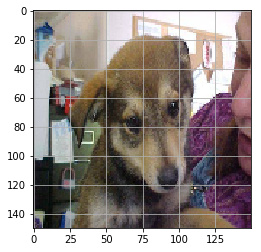

(1, 150, 150, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19_input (InputLayer)     (None, 150, 150, 3)       0         
_________________________________________________________________
vgg19 (Model)                (None, 4, 4, 512)         20024384  
Total params: 20,024,384
Trainable params: 9,439,232
Non-trainable params: 10,585,152
_________________________________________________________________
None
(1, 4, 4, 512)
(1, 4, 4, 512)


In [26]:
features_cat = []
for i in (os.listdir(validation_cats_dir)[:5]): # REMOVE [:5] WHEN RUNNING FOR ALL IMAGES 
  
  im_path = validation_cats_dir +'/'+ i
  feature = activation_model(model_path, im_path)
  feature_np = np.array(feature)
  print(feature_np.shape)
  features_cat.append(feature_np.flatten())
  
features_dog = []
# REMOVE [:5] WHEN RUNNING FOR ALL IMAGES 
for i in (os.listdir(validation_dogs_dir)[:5]):
  
  im_path = validation_dogs_dir +'/'+ i
  feature = activation_model(model_path, im_path)
  feature_np = np.array(feature)
  print(feature_np.shape)
  features_dog.append(feature_np.flatten())

In [27]:
import pandas as pd


feat_cols = [ 'pixel'+str(i) for i in range(8192) ]

df = pd.DataFrame(features_cat,columns=feat_cols)
df['label'] = 0
df['label'] = df['label'].apply(lambda i: str(i))
df_dog = pd.DataFrame(features_dog,columns=feat_cols)
df_dog['label'] = 1
df_dog['label'] = df_dog['label'].apply(lambda i: str(i))

df =df.append(df_dog).reset_index(drop=True)


df

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel8183,pixel8184,pixel8185,pixel8186,pixel8187,pixel8188,pixel8189,pixel8190,pixel8191,label
0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0
1,0.000000,0.0,0.000000,0.0,0.0,0.000000,3.440140,0.000000,0.0,0.0,...,9.115542,0.0,52.046852,0.000000,0.000000,0.000000,0.000000,0.0,1.349637,0
2,4.980855,0.0,23.647581,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0
3,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,32.606899,101.587700,14.710503,0.000000,1.930546,0.0,0.000000,0
4,0.000000,0.0,0.000000,0.0,0.0,0.000000,29.365181,6.609588,0.0,0.0,...,0.000000,0.0,21.421768,17.619455,0.000000,0.000000,0.000000,0.0,0.000000,0
5,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,28.667225,0.0,0.000000,0.000000,0.000000,0.000000,21.317940,0.0,12.012191,1
6,19.049360,0.0,67.837578,0.0,0.0,16.606379,0.000000,48.076618,0.0,0.0,...,53.703888,0.0,0.000000,0.000000,0.000000,2.634137,0.000000,0.0,76.369720,1
7,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,60.107189,1
8,0.000000,0.0,0.000000,0.0,0.0,0.000000,66.838783,0.000000,0.0,0.0,...,33.626163,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,81.281403,1
9,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,57.922413,0.0,39.279495,0.000000,0.000000,0.000000,0.000000,0.0,39.248165,1


In [28]:
import time

from sklearn.manifold import TSNE

n_sne = 7000

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
df_tsne = df.loc[:, df.columns != 'label'].copy()

tsne_results = tsne.fit_transform(df_tsne)

[t-SNE] Computing 9 nearest neighbors...
[t-SNE] Indexed 10 samples in 0.001s...
[t-SNE] Computed neighbors for 10 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 10 / 10
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.142975
[t-SNE] KL divergence after 300 iterations: 0.265834


In [29]:
tsne_results[:,1]

array([  60.20954 , -138.78615 , -147.30943 ,  -32.99263 ,  -15.585275,
       -108.72491 ,  -47.624878,  -49.08873 ,  108.35913 ,   50.194122],
      dtype=float32)

In [0]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})
def plot_scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    print(num_classes)
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    #ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

2


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


(<Figure size 576x576 with 1 Axes>,
 [Text(nan, nan, '0'), Text(nan, nan, '1')])

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


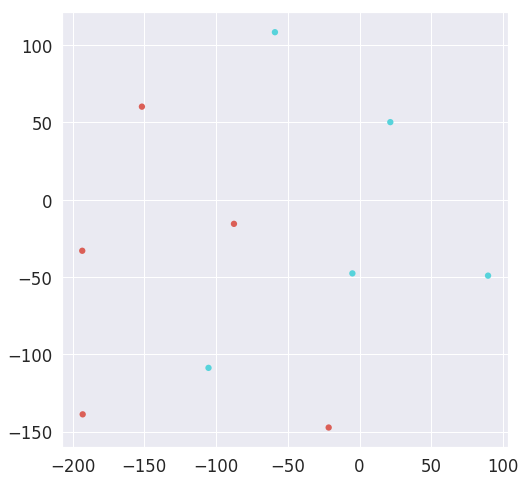

In [31]:
# Visualize the tsne plot 
plot_scatter(tsne_results,df['label'])